In [1]:
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/Users/brunonishimoto/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def create_simple_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

def create_mobilenet_model():
    mobile_net = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights=None,
        input_shape=[256, 256, 3],
        pooling='max')

    kernel_initializer = tf.keras.initializers.glorot_uniform(seed=1337)
    model = tf.keras.Sequential()

    model.add(mobile_net)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer = kernel_initializer))
    
    return model

In [3]:
normal_generator = ImageDataGenerator(
  data_format="channels_last",
  rescale = 1. / 255,
  validation_split = 0.4
)

train_batches = normal_generator.flow_from_directory(
    batch_size=32,
    directory='./dataset/train',
    target_size=(256, 256),
    class_mode='binary',
    subset='training'
)

validation_batches = normal_generator.flow_from_directory(
    batch_size=32,
    directory='./dataset/train',
    target_size=(256, 256),
    class_mode='binary',
    subset='validation'
)

modified_generator = ImageDataGenerator(
  data_format="channels_last",
  rescale = 1. / 255,
  validation_split = 0.4
)

train_batches_modified = modified_generator.flow_from_directory(
    batch_size=32,
    directory='./dataset/train_modified',
    target_size=(256, 256),
    class_mode='binary',
    subset='training'
)

validation_batches_modified = modified_generator.flow_from_directory(
    batch_size=32,
    directory='./dataset/train_modified',
    target_size=(256, 256),
    class_mode='binary',
    subset='validation'
)

Found 75774 images belonging to 2 classes.
Found 50514 images belonging to 2 classes.
Found 75774 images belonging to 2 classes.
Found 50514 images belonging to 2 classes.


[0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 1. 1. 1.]


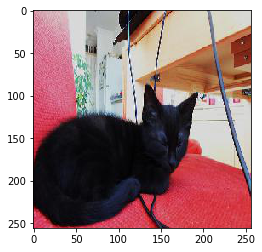

In [6]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
imshow(train_batches[0][0][0])
print(train_batches[0][1])

In [18]:
unique, counts = np.unique(train_batches.classes, return_counts=True)
class_weigths = dict(zip(unique, np.true_divide(counts.sum(), 2*counts)))

In [19]:
model_simple = create_simple_model()

In [20]:
model_simple.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 51, 51, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 51, 51, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                591904    
__________

In [22]:
start = time.time()
history = model_simple.fit_generator(train_batches,
                    epochs=30,
                    verbose=1,
                    steps_per_epoch=len(train_batches),
                    validation_data=validation_batches,
                    initial_epoch=0,
                    class_weight=class_weigths,
                    validation_steps=len(validation_batches)
                   ) 
end = time.time()
print('Time to train: %.2fmin' % ((end - start) / 60))

Epoch 1/30
  10/2368 [..............................] - ETA: 1:35:33 - loss: 1.0227 - acc: 0.5563

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

epochs = history.epoch
acc = history.history['val_acc']

fig, ax = plt.subplots()
ax.plot(epochs, acc)
ax.grid(True, linestyle='-.')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')


plt.show()

In [ ]:
test_generator = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255
)

test_batches = test_generator.flow_from_directory(
    batch_size=1,
    directory='./dataset/test_modified',
    target_size=[256, 256],
    class_mode='binary'
)

In [ ]:
score = model.evaluate_generator(test_batches, verbose=1)

print(model.metrics_names)
print('test dataset: ' + str(score))